In [42]:
import cv2
import torch
import groundingdino.datasets.transforms as T

import os

from groundingdino.util.inference import load_model, load_image, predict, annotate


In [43]:
# ---------------------------
# CONFIG
# ---------------------------
config_path = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
weights_path = "GroundingDINO/weights/groundingdino_swint_ogc.pth"
output_dir = "labels"  # YOLO labels folder
class_name = "whale"
text_prompt = "whale"

# ---------------------------
# Load model
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model(config_path, weights_path, device=device)

final text_encoder_type: bert-base-uncased


In [48]:
input_image = "000a8f2d5c316a.jpg"
image_source, image_transformed = load_image(input_image)

boxes, logits, phrases = predict(
    model=model,
    image=image_transformed,
    caption=text_prompt,
    box_threshold=0.4,
    text_threshold=0.25
)




In [50]:
import torchvision

keep = torchvision.ops.nms(boxes, logits, iou_threshold=0.5)
boxes = boxes[keep]
logits = logits[keep]
phrases = [phrases[i] for i in keep]
print(phrases)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

['whale']


In [39]:
res = input_image.split('.')
res = res[0] + "_boxed." + res[1]
cv2.imwrite(res, cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))


True

In [40]:
h, w, _ = image_source.shape

os.makedirs("labels", exist_ok=True)
label_file = os.path.join("labels", os.path.splitext(os.path.basename(input_image))[0] + ".txt")

with open(label_file, "w") as f:
    for box in boxes:
        x_min, y_min, x_max, y_max = box.tolist()

        # convert to YOLO format (normalized cx, cy, w, h)
        cx = ((x_min + x_max) / 2) / w
        cy = ((y_min + y_max) / 2) / h
        bw = (x_max - x_min) / w
        bh = (y_max - y_min) / h

        class_id = 5
        f.write(f"{class_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

print(f"YOLO label saved to {label_file}")

YOLO label saved to labels/000a8f2d5c316a.txt


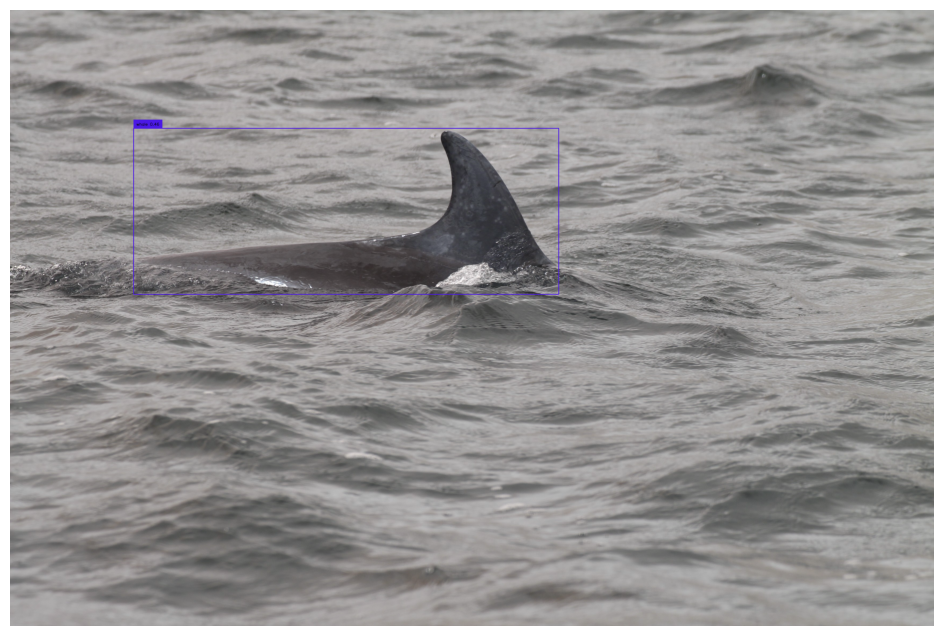

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(annotated_frame)
plt.axis("off")
plt.show()